# Training Notebook
Complete training pipeline for diabetes dataset.

In [ ]:
# imports and helper functions
import os
import json
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, accuracy_score, classification_report
import joblib

In [5]:
# plotting defaults
sns.set(style='whitegrid')


# small helpers
def plot_roc(model, X, y, title='ROC', savepath=None):
    probs = model.predict_proba(X)[:,1]
    fpr, tpr, _ = roc_curve(y, probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f'AUC={roc_auc:.3f}')
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(title)
    plt.legend()
    if savepath:
        plt.savefig(savepath, bbox_inches='tight')
    plt.show()




def plot_confusion(cm, labels=[0,1], savepath=None):
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    if savepath:
        plt.savefig(savepath, bbox_inches='tight')
    plt.show()



def ensure_dirs(outdir='models'):
    Path(outdir).mkdir(parents=True, exist_ok=True)
    Path(outdir, 'plots').mkdir(parents=True, exist_ok=True)
    Path(outdir, 'artifacts').mkdir(parents=True, exist_ok=True)

## Load Data

In [7]:
# load data
DATA_PATH = Path('../data/diabetes_clean.csv')
assert DATA_PATH.exists(), f"File not found: {DATA_PATH}. Put your cleaned csv there."


df = pd.read_csv(DATA_PATH)


df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,0
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


## Train / Validation / Test split (60/20/20)

In [8]:
# split
RANDOM_STATE = 42


X = df.drop(columns='Outcome')
y = df['Outcome']


# 20% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
# of remaining 80%, take 25% -> 0.25*0.8 = 0.2 overall
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=RANDOM_STATE)


print('Shapes — Train / Val / Test:')
print(X_train.shape, X_val.shape, X_test.shape)

Shapes — Train / Val / Test:
(460, 8) (154, 8) (154, 8)


## Baseline models (quick) — DecisionTree, RandomForest, XGBoost

In [9]:
results = {}


# Decision Tree
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
dt.fit(X_train, y_train)
results['DecisionTree'] = roc_auc_score(y_val, dt.predict_proba(X_val)[:,1])


# Random Forest
rf = RandomForestClassifier(random_state=RANDOM_STATE)
rf.fit(X_train, y_train)
results['RandomForest'] = roc_auc_score(y_val, rf.predict_proba(X_val)[:,1])


# XGBoost
xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=RANDOM_STATE)
xgb.fit(X_train, y_train)
results['XGBoost'] = roc_auc_score(y_val, xgb.predict_proba(X_val)[:,1])


results

/Users/tapi/playground/machine-learning-zoomcamp/projects/diabetes_mid_project/diabetes_venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [16:33:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


{'DecisionTree': 0.7305555555555556,
 'RandomForest': 0.8593518518518519,
 'XGBoost': 0.8224074074074075}

## Cross-validation report

In [10]:
# cross validation for chosen baseline (RandomForest example)
from sklearn.model_selection import StratifiedKFold, cross_val_score


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_scores = cross_val_score(RandomForestClassifier(random_state=RANDOM_STATE), pd.concat([X_train, X_val]), pd.concat([y_train, y_val]), cv=skf, scoring='roc_auc')
print('RF CV mean/std:', cv_scores.mean(), cv_scores.std())

RF CV mean/std: 0.8201266611295681 0.008858586686930741


## Hyperparameter tuning: RandomForest and XGBoost

In [11]:
# tune RandomForest
rf_param_grid = {
'n_estimators': [50, 100, 200],
'max_depth': [None, 5, 10],
'min_samples_split': [2, 5],
'min_samples_leaf': [1, 2]
}


grid_rf = GridSearchCV(RandomForestClassifier(random_state=RANDOM_STATE), rf_param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)
print('Best RF params:', grid_rf.best_params_)


# quick cv on full train+val
best_rf = grid_rf.best_estimator_
from sklearn.model_selection import cross_val_score
cv_best_rf = cross_val_score(best_rf, pd.concat([X_train, X_val]), pd.concat([y_train, y_val]), cv=skf, scoring='roc_auc')
print('Tuned RF CV mean/std:', cv_best_rf.mean(), cv_best_rf.std())


# Cell 6b: tune XGBoost (smaller grid)
xgb_param_grid = {
'n_estimators': [50, 100, 150],
'max_depth': [3, 5],
'learning_rate': [0.01, 0.1]
}


grid_xgb = GridSearchCV(XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=RANDOM_STATE), xgb_param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_xgb.fit(X_train, y_train)
print('Best XGB params:', grid_xgb.best_params_)


best_xgb = grid_xgb.best_estimator_
cv_best_xgb = cross_val_score(best_xgb, pd.concat([X_train, X_val]), pd.concat([y_train, y_val]), cv=skf, scoring='roc_auc')
print('Tuned XGB CV mean/std:', cv_best_xgb.mean(), cv_best_xgb.std())

Fitting 3 folds for each of 36 candidates, totalling 108 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for 

Best RF params: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Tuned RF CV mean/std: 0.8374404761904761 0.013244328287071054
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best XGB params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


/Users/tapi/playground/machine-learning-zoomcamp/projects/diabetes_mid_project/diabetes_venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [16:35:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/tapi/playground/machine-learning-zoomcamp/projects/diabetes_mid_project/diabetes_venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [16:35:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/tapi/playground/machine-learning-zoomcamp/projects/diabetes_mid_project/diabetes_venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [16:35:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/

Tuned XGB CV mean/std: 0.8253889811738648 0.02086310312546955


/Users/tapi/playground/machine-learning-zoomcamp/projects/diabetes_mid_project/diabetes_venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [16:35:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/tapi/playground/machine-learning-zoomcamp/projects/diabetes_mid_project/diabetes_venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [16:35:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/tapi/playground/machine-learning-zoomcamp/projects/diabetes_mid_project/diabetes_venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [16:35:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## Compare tuned models on validation and pick the best

In [13]:
# compare on validation
rf_val = roc_auc_score(y_val, best_rf.predict_proba(X_val)[:,1])
xgb_val = roc_auc_score(y_val, best_xgb.predict_proba(X_val)[:,1])
print('RF val AUC:', rf_val)
print('XGB val AUC:', xgb_val)


if rf_val >= xgb_val:
    selected_name = 'RandomForest'
    selected_model = best_rf
else:
    selected_name = 'XGBoost'
    selected_model = best_xgb


print('Selected model:', selected_name)

RF val AUC: 0.8662962962962963
XGB val AUC: 0.869537037037037
Selected model: XGBoost


## Retrain selected model on Train+Val (full training) and evaluate on Test

Final Test AUC: 0.822037037037037
Accuracy: 0.7467532467532467
Confusion matrix:
 [[85 15]
 [24 30]]


/Users/tapi/playground/machine-learning-zoomcamp/projects/diabetes_mid_project/diabetes_venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [16:37:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


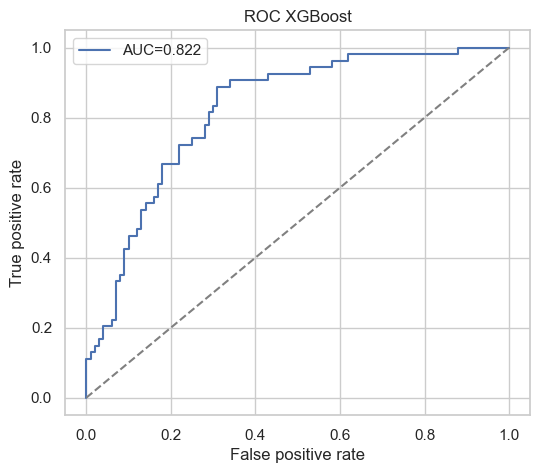

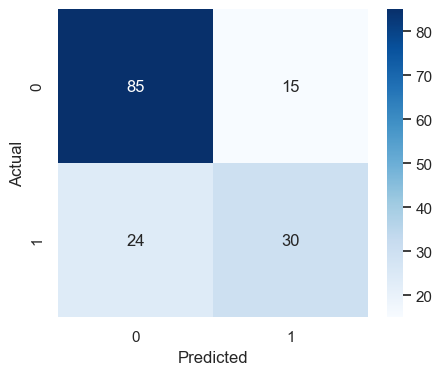

In [14]:
# retrain on train+val and final eval
X_full = pd.concat([X_train, X_val]).reset_index(drop=True)
y_full = pd.concat([y_train, y_val]).reset_index(drop=True)


selected_model.fit(X_full, y_full)


# Evaluate on test
probs_test = selected_model.predict_proba(X_test)[:,1]
preds_test = selected_model.predict(X_test)


final_auc = roc_auc_score(y_test, probs_test)
acc = accuracy_score(y_test, preds_test)
cm = confusion_matrix(y_test, preds_test)
report = classification_report(y_test, preds_test, output_dict=True)


print('Final Test AUC:', final_auc)
print('Accuracy:', acc)
print('Confusion matrix:\n', cm)


plot_roc(selected_model, X_test, y_test, title=f'ROC {selected_name}', savepath=f'models/plots/roc_{selected_name}.png')
plot_confusion(cm, savepath=f'models/plots/cm_{selected_name}.png')

- True Negatives (TN) = 85 → correctly predicted no diabetes
- False Positives (FP) = 15 → predicted diabetes but actually healthy
- False Negatives (FN) = 24 → predicted healthy but actually diabetes (important!)
- True Positives (TP) = 30 → correctly predicted diabetes

Interpretation:
- Accuracy: ~74.7% → overall correctness.
- Model performs better at identifying healthy patients (Class 0) than diabetic patients (Class 1).
- Recall for diabetes (TP / (TP + FN)) = 30 / (30+24) ≈ 0.555 → we miss ~45% of diabetic cases.
- Precision for diabetes (TP / (TP + FP)) = 30 / (30+15) ≈ 0.667 → when it predicts diabetes, it's right 66% of the time.

💡 Takeaway: The model is reasonably good overall, but could benefit from further improvement to catch more diabetic patients (reducing false negatives). Maybe try class weighting, SMOTE, or other threshold tuning.

## Save model, params, metrics, and registry entry

In [15]:
# save artifacts
ensure_dirs('models')


model_path = Path('models') / f'{selected_name.lower()}_model.pkl'
joblib.dump(selected_model, model_path)


metadata = {
'selected_model': selected_name,
'selected_params': selected_model.get_params(),
'rf_best_params': grid_rf.best_params_,
'xgb_best_params': grid_xgb.best_params_,
'final_test_auc': float(final_auc),
'final_test_accuracy': float(acc),
'confusion_matrix': cm.tolist(),
'classification_report': report,
'timestamp': datetime.utcnow().isoformat()
}


# Save metadata and summary
(Path('models') / 'artifacts' / 'metadata.json').write_text(json.dumps(metadata, indent=2))
(Path('models') / 'artifacts' / 'summary.json').write_text(json.dumps({'model_path': str(model_path), 'test_auc': final_auc}, indent=2))


print('Saved model and metadata to models/')

Saved model and metadata to models/


/var/folders/4d/vjwz0rnd5_b7jqryzlkcq_y80000gn/T/ipykernel_59006/1000218114.py:18: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  'timestamp': datetime.utcnow().isoformat()


# Quick visualization: feature importance (for tree-based model)

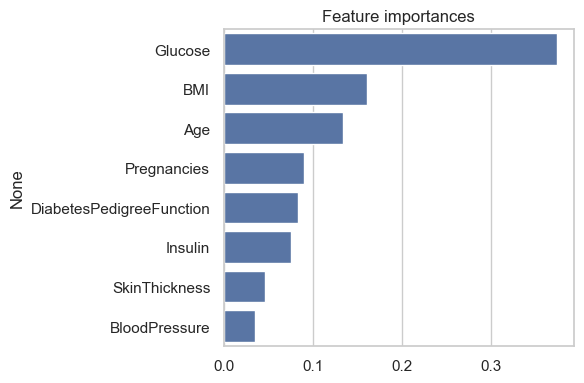

In [18]:
# feature importance
if hasattr(selected_model, 'feature_importances_'):
    fi = pd.Series(selected_model.feature_importances_, index=X.columns).sort_values(ascending=False)
    plt.figure(figsize=(6,4))
    sns.barplot(x=fi.values, y=fi.index)
    plt.title('Feature importances')
    plt.tight_layout()
    plt.show()
else:
    print('Model has no feature_importances_ attribute')

In [ ]:
# End of notebook